In [1]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [2]:
degree = 5
n_nodes = 10
rate = 0.8
T = 10
dt = 0.01
fprefix = 'data/rrg_sis_'
train_sample = 51000
val_sample = 1000


In [3]:
# Generating the network
graph = nx.random_regular_graph(degree, n_nodes)
#graph = nx.barabasi_albert_graph(n_nodes, 3)
nx.write_edgelist(graph, fprefix + 'edgelist.b')
    
# Generating the dataset
transform = [dl.SIS_StateToFloat(), dl.ResizeData((1, n_nodes))]
dataset = dl.SISDataset(rate)
dataset.generate(graph, train_sample, T, init_active=0.01, dt=0.01, pre_transform=transform)

In [4]:
dataset[0][0].size(), dataset[0][1].size()

(torch.Size([1, 10]), torch.Size([1, 10]))

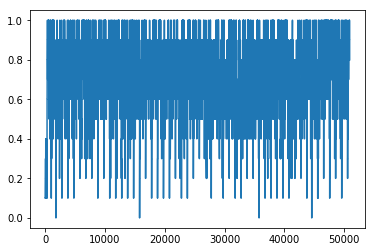

In [5]:
def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_train_dataset(dataset)
plt.plot(avg)
plt.show()

In [6]:
n_hidden = [128, 64]
n_embedding = 10
optimizer = lambda p: torch.optim.Adam(p, lr=1e-3, weight_decay=0)
keepprob=0.8
use_cuda = torch.cuda.is_available()
loss = torch.nn.BCELoss(reduction='sum')

model = dl.basicMarkovDegreeVAE(graph, n_hidden, n_embedding, keepprob=keepprob,
                                optimizer=optimizer, loss=loss, use_cuda=use_cuda)

In [9]:
new_lr = 1e-4
for g in model.optimizer.param_groups:
    g['lr'] = new_lr

In [10]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset) - val_sample, val_sample])
model.fit(train_dataset, val_dataset,
          epochs=10,
          batch_size=128,
          metrics=["recon", "kl_div"],
          show_var=False)

Epoch: 11 - Time: 30.77
New best Epoch: 12 - Time: 29.80
	 Train. - loss: 0.2009, recon: 0.0463, kl_div: 0.1546, 
	 Val. - loss: 0.1703, recon: 0.0450, kl_div: 0.1253, 
Epoch: 13 - Time: 29.63
New best Epoch: 14 - Time: 29.44
	 Train. - loss: 0.2024, recon: 0.0544, kl_div: 0.1480, 
	 Val. - loss: 0.1615, recon: 0.0417, kl_div: 0.1198, 
Epoch: 15 - Time: 29.41
Epoch: 16 - Time: 29.34
Epoch: 17 - Time: 29.41
New best Epoch: 18 - Time: 34.70
	 Train. - loss: 0.2014, recon: 0.0552, kl_div: 0.1463, 
	 Val. - loss: 0.1593, recon: 0.0408, kl_div: 0.1184, 
Epoch: 19 - Time: 29.78
New best Epoch: 20 - Time: 29.68
	 Train. - loss: 0.2046, recon: 0.0499, kl_div: 0.1547, 
	 Val. - loss: 0.1559, recon: 0.0307, kl_div: 0.1252, 


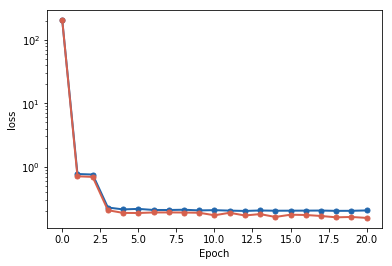

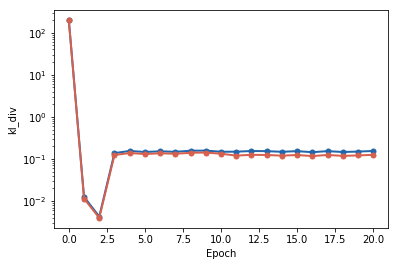

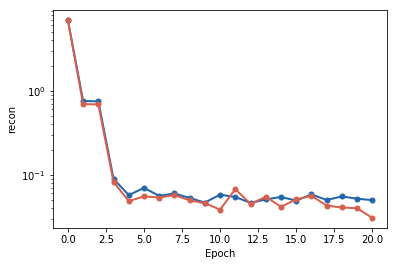

In [11]:
fig, ax = model.history.plot(training_metrics=['loss', 'kl_div', 'recon'])
for k in ax:
    #ax[k].set_xscale('log')
    ax[k].set_yscale('log')
plt.show()

In [10]:
def test_model(learned_model, dataset):
    init_states = dataset[0][1]
    t = 0
    states, z, past_states = learned_model.predict(init_states, batch_size=2)    
    learned_avg = [np.mean(states)]
    
    while(t < T):
        t += dt
        states, z, past_states = learned_model.predict(past_states, batch_size=2)
        states = states[0]
        learned_avg.append(np.mean(states))
        states = torch.bernoulli(torch.tensor(states))
        past_states = states
    
    return learned_avg

def show_train_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

def show_dataset(dataset):
    avg = []
    t = 0
    sisnet = dl.dynamics.SISNetwork(graph, rate, dt=dt,
                                    filename=None,
                                    full_data_mode=False,
                                    overwrite=True)
    while t < T:
        t += dt
        sisnet.update(record=False)
        avg_state, std_state = sisnet.get_avg_activity()
        avg.append(avg_state['I'])
    return avg


In [ ]:
null_model = dl.basicMarkovDegreeVAE(graph, n_hidden, n_embedding, optimizer=optimizer, loss=loss, use_cuda=use_cuda)

avg_ts = show_dataset(dataset)
trained_ts = test_model(model, dataset)
untrained_ts = test_model(null_model, dataset)

#avg_ts = show_train_dataset(dataset)


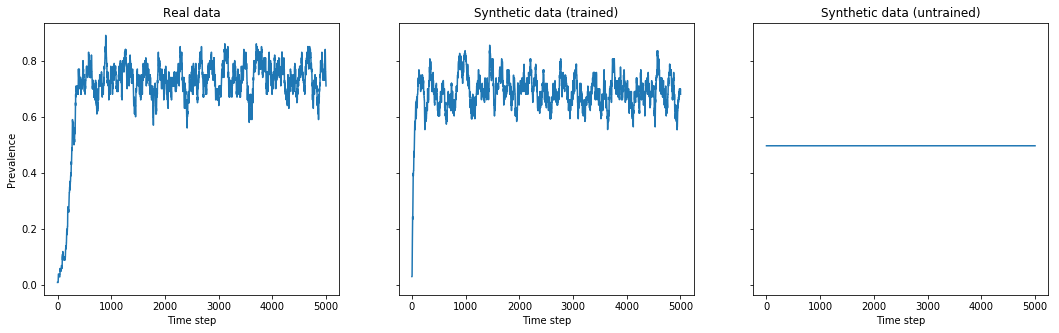

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True,sharey=True)

ax[0].plot(avg_ts)
ax[0].set_title('Real data')
ax[0].set_ylabel('Prevalence')
ax[0].set_xlabel('Time step')

ax[1].plot(trained_ts)
ax[1].set_title('Synthetic data (trained)')
ax[1].set_xlabel('Time step')

ax[2].plot(untrained_ts)
ax[2].set_title('Synthetic data (untrained)')
ax[2].set_xlabel('Time step')

figname = "shared_degreemodel_evol_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
# fig.savefig("fig/png/" + figname + ".png")
# fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()

In [12]:
def reconstruction_dataset(model, dataset, verbose=True):
    learned = np.zeros(len(dataset))
    real = np.zeros(len(dataset))
    
    for i, d in enumerate(dataset):
        
        if i%1000==0 and verbose: print(str(i) + "/" + str(len(dataset)))
        present, past = d
        sample, _, _ = model.predict(past, batch_size=2)
        learned[i] = np.mean(sample)
        real[i] = np.mean(present.numpy())
        
    return real, learned
        
    

In [13]:
real, learned = reconstruction_dataset(model, dataset, True)

0/50948
1000/50948
2000/50948
3000/50948
4000/50948
5000/50948
6000/50948
7000/50948
8000/50948
9000/50948
10000/50948
11000/50948
12000/50948
13000/50948
14000/50948
15000/50948
16000/50948
17000/50948
18000/50948
19000/50948
20000/50948
21000/50948
22000/50948
23000/50948
24000/50948
25000/50948
26000/50948
27000/50948
28000/50948
29000/50948
30000/50948
31000/50948
32000/50948
33000/50948
34000/50948
35000/50948
36000/50948
37000/50948
38000/50948
39000/50948
40000/50948
41000/50948
42000/50948
43000/50948
44000/50948
45000/50948
46000/50948
47000/50948
48000/50948
49000/50948
50000/50948


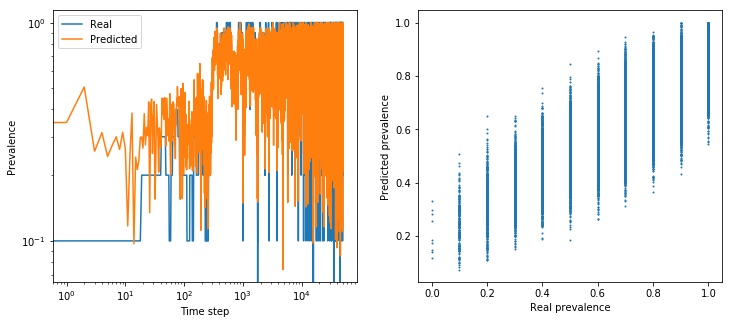

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real, '-', label='Real')
ax[0].plot(learned, '-', label='Predicted')

ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(real, learned, '.', markersize=2)
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Predicted prevalence')

figname = "shared_degreemodel_recon_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
#fig.savefig("fig/png/" + figname + ".png")
#fig.savefig("fig/pdf/" + figname + ".pdf")
plt.show()


In [29]:
all_states = dataset.enumerate_all_states(graph)
markovProb = np.zeros([len(all_states), len(all_states)])

for i, past in enumerate(all_states):
    prob = dataset.get_transition_probability(graph, past, dt)
    for j, present in enumerate(all_states):
        present_prob = present * prob + (1 - present) * (1 - prob)
        markovProb[i, j] = np.prod(present_prob)

markovProb /= np.sum(markovProb, 0)

In [30]:
learnedProb = np.zeros([len(all_states), len(all_states)])
for i, past in enumerate(all_states):
    _past = torch.tensor(past).float()
    prob, _, _ = model.predict(_past, batch_size=128)
    avg_prob = np.mean(prob, 0)
    for j, present in enumerate(all_states):
        present_prob = present * avg_prob + (1 - present) * (1 - avg_prob)
        learnedProb[i, j] = np.prod(present_prob)
learnedProb /= np.sum(learnedProb, 0)
#learnedProb = np.log(learnedProb)

null_model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding, 
                                       keepprob=1, optimizer=optimizer,
                                       loss=loss, use_cuda=use_cuda)
nullProb = np.zeros([len(all_states), len(all_states)])
for i, past in enumerate(all_states):
    _past = torch.tensor(past).float()
    prob, _, _ = null_model.predict(_past, batch_size=128)
    avg_prob = np.mean(prob, 0)
    for j, present in enumerate(all_states):
        present_prob = present * avg_prob + (1 - present) * (1 - avg_prob)
        nullProb[i, j] = np.prod(present_prob)

nullProb /= np.sum(nullProb, 0)

/home/charles/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


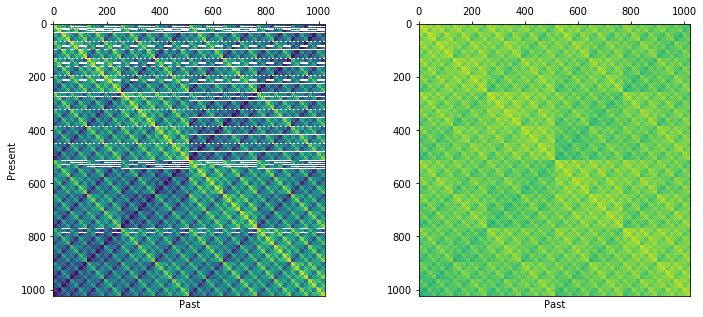

In [33]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cs = ax[0].imshow(np.log(markovProb), origin='upper', vmin=-40, vmax=0)
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Past')
ax[0].set_ylabel('Present')

ax[1].imshow(np.log(learnedProb), origin='upper', vmin=-40, vmax=0)
ax[1].xaxis.tick_top()
ax[1].set_xlabel('Past')

# ax[2].imshow(nullProb, origin='upper', vmin=-40, vmax=0)
# ax[2].xaxis.tick_top()
# ax[2].set_xlabel('Past')
# plt.colorbar(cs, ax=ax[2])

figname = "shared_degreemodel_trans_rrgsis_d{0}_n{1}_rate{2}".format(degree, n_nodes, rate)
# fig.savefig("fig/png/" + figname + ".png")
# fig.savefig("fig/pdf/" + figname + ".pdf")

plt.show()